In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import time
import copy 
import datetime

import neuralnetwork as nn
import mlutilities as ml
import dataloader as dl

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
df = pd.read_csv('../../data/preprocessed.csv', sep=',')
X = df.iloc[:,3:11].values
T = df.iloc[:,16:].values
X.shape, T.shape

((177, 8), (177, 2))

In [13]:
df.head()

,lat,lon,date,G8,G9,G10,G11,G13,G14,G15,G16,P_s,T_s,Td_s,P_n,T_n,T_r,Td_r
0,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,985,30.051764,30.755556,21.644444
1,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,980,29.679932,29.200000,21.200000
2,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,975,29.308099,28.800000,21.081818
3,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,970,28.853162,28.400000,20.963636
4,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,965,28.398224,28.000000,20.845455


In [14]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, 0.80, shuffle=True)

In [15]:
def plot_results(nnet, X, df):
    Y = nnet.use(X)

    fig = plt.figure(figsize=(7, 9))
    skew = SkewT(fig, rotation=45)
    skew.plot(df['P_n'], df['T_n'], 'k', alpha=0.2);
    skew.plot(df['P_n'], df['T_r'], 'r');
    skew.plot(df['P_n'], Y[:, 0], 'b');

    skew.plot(df['P_n'], df['Td_r'], 'g');
    skew.plot(df['P_n'], Y[:, 1], 'orange');

    skew.ax.set_xlim(-30, 35);

## TensorFlow

In [16]:
class TrainLogger(tf.keras.callbacks.Callback):
    
    def __init__(self, n_epochs, step=10):
        self.step = step
        self.n_epochs = n_epochs
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.step == 0:
            print(f"epoch: {epoch}, loss: {logs['loss']:7.5f}")
        elif epoch + 1 == self.n_epochs:
            print(f"epoch: {epoch}, loss: {logs['loss']:7.5f}")
            print('finished!')

In [6]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, activation='tanh'):
        
        if not isinstance(n_hiddens_list, list):
            raise Exception(
                f'{type(self).__name__}: n_hiddens_list must be a list.')
        
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        
        X = tf.keras.Input(shape=(n_inputs,))
        Z = X
        for i, units in enumerate(n_hiddens_list):
            Z = tf.keras.layers.Dense(units, activation=activation)(Z)
        Y = tf.keras.layers.Dense(n_outputs)(Z)

        self.model = tf.keras.Model(inputs=X, outputs=Y)
        
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.history = None
        self.training_time = None
    
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
        if self.history:
            str += f"\n  Final objective value is {self.history['loss'][-1]:.5f} in {self.training_time:.4f} seconds."
        else:
            str += '  Network is not trained.'
        return str
    
    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
            
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans
    
    def train(self, X, T, n_epochs, batch_size, method='scg',
              verbose=False, learning_rate=0.001):
        """Use Keras Functional API to train model"""
        
        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
    
        try:
            algo = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam][[
                'sgd', 'adam'].index(method)]
        except:
            raise Exception(
                "train: method={method} not one of 'scg' or 'adam'")

        self.model.compile(optimizer=algo(learning_rate),
                      loss=tf.keras.losses.MSE, 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        callback = None
        if verbose:
            log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            callback = [TrainLogger(n_epochs, step=1000),
                        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]
        start_time = time.time()
        self.history = self.model.fit(X, T, batch_size=batch_size, epochs=n_epochs,
                                      verbose=0, callbacks=callback).history
        self.training_time = time.time() - start_time
        return self
    
    def use(self, X):
        X = self._standardizeX(X)
        Y = self._unstandardizeT(self.model.predict(X))
        return Y

In [7]:
!rm -rf ./logs/ 
nnet = NeuralNetwork(Xtrain.shape[1], [50, 50, 50], Ttrain.shape[1], activation='tanh')
nnet.train(Xtrain, Ttrain, 100, Xtrain.shape[0], method='adam', verbose=True, learning_rate=0.001)


epoch: 0, loss: 1.74099
epoch: 99, loss: 0.01237
finished!


NeuralNetwork(13, [50, 50, 50], 2)
  Final objective value is 0.01237 in 0.7661 seconds.

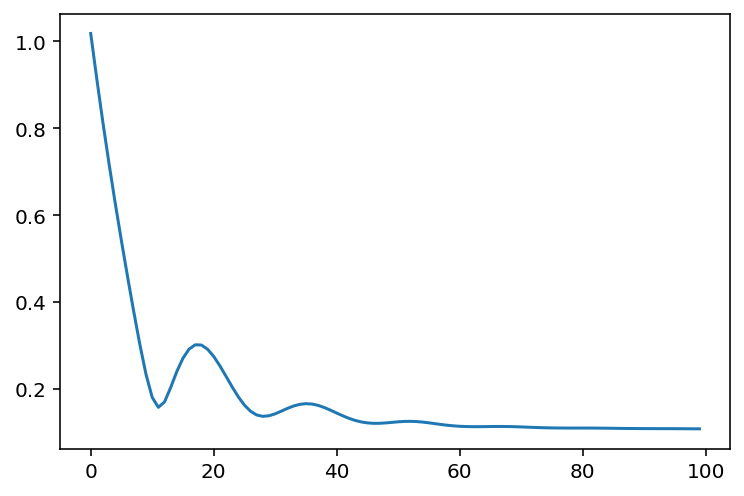

In [18]:
plt.plot(nnet.history['root_mean_squared_error'])

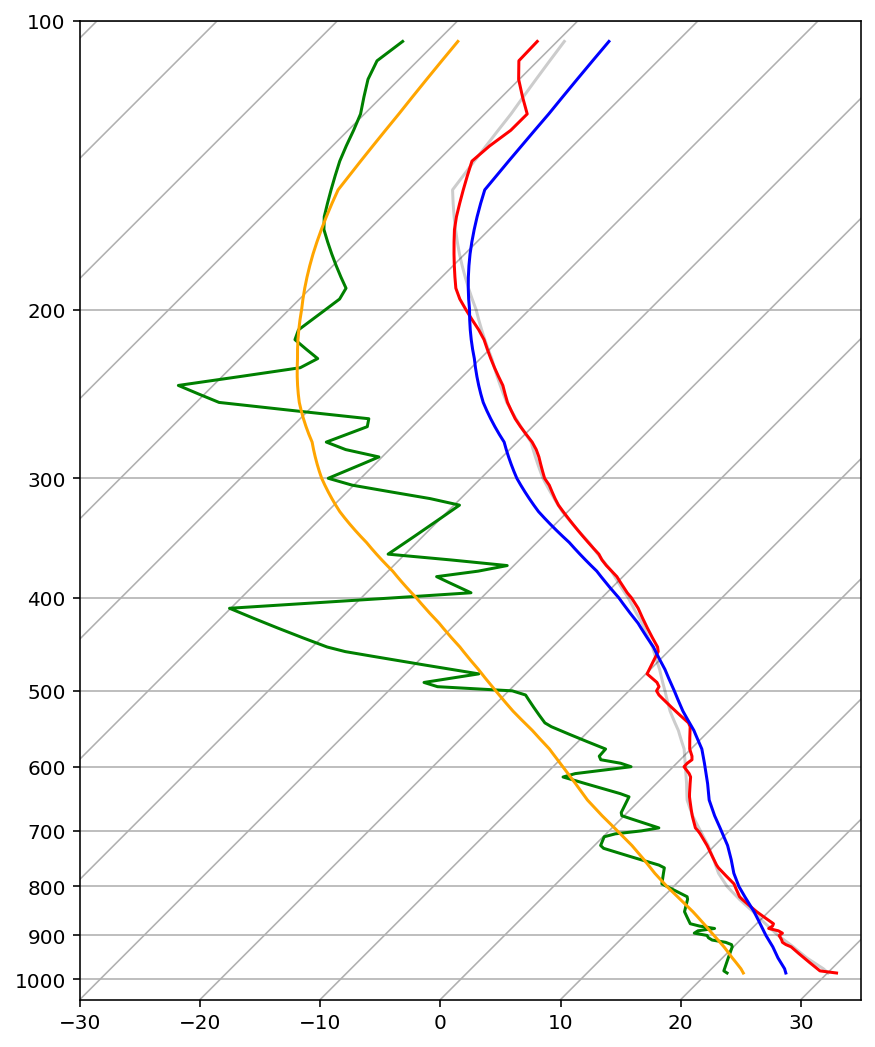

In [19]:
plot_results(nnet, X, df)

## Custom NN

In [20]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [50, 50, 50], Ttrain.shape[1], activation='tanh')
nnet.train(Xtrain, Ttrain, 1000, method='adam', verbose=False, learning_rate=0.001)

NeuralNetwork(13, [50, 50, 50], 2)
   Network was trained for 1000 epochs that took 0.8342 seconds. Final objective value is 0.065

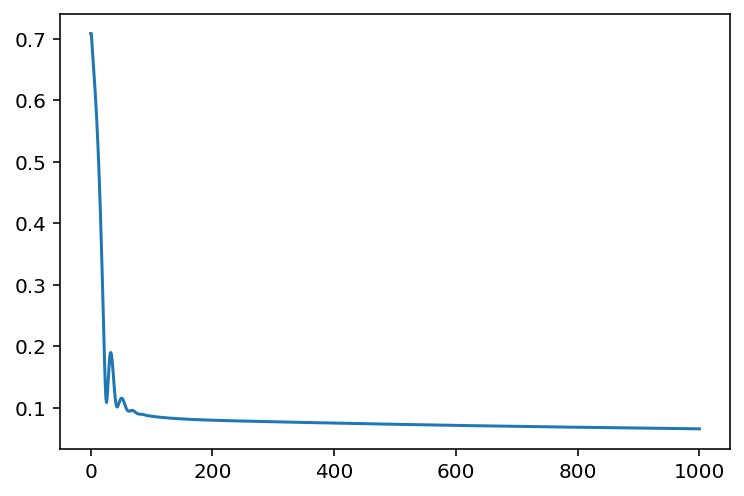

In [11]:
plt.plot(nnet.get_error_trace());

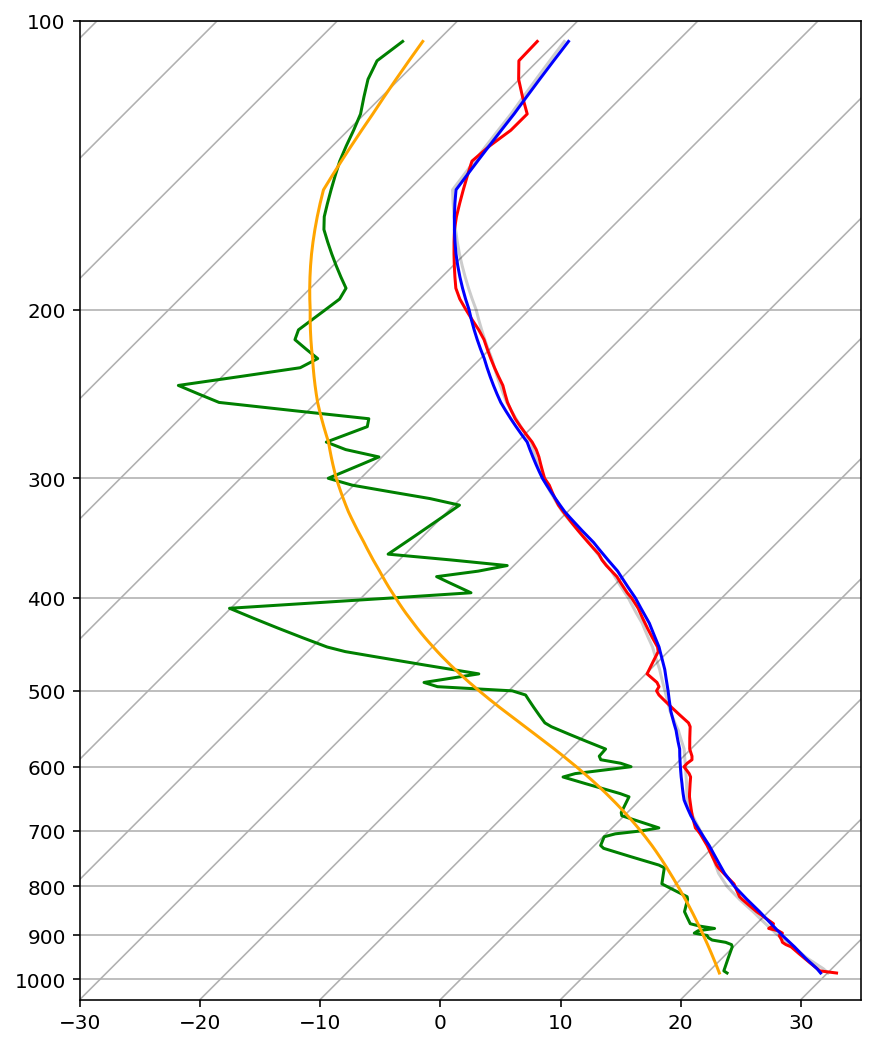

In [12]:
plot_results(nnet, X, df)

FloatProgress(value=0.0, max=17.0)

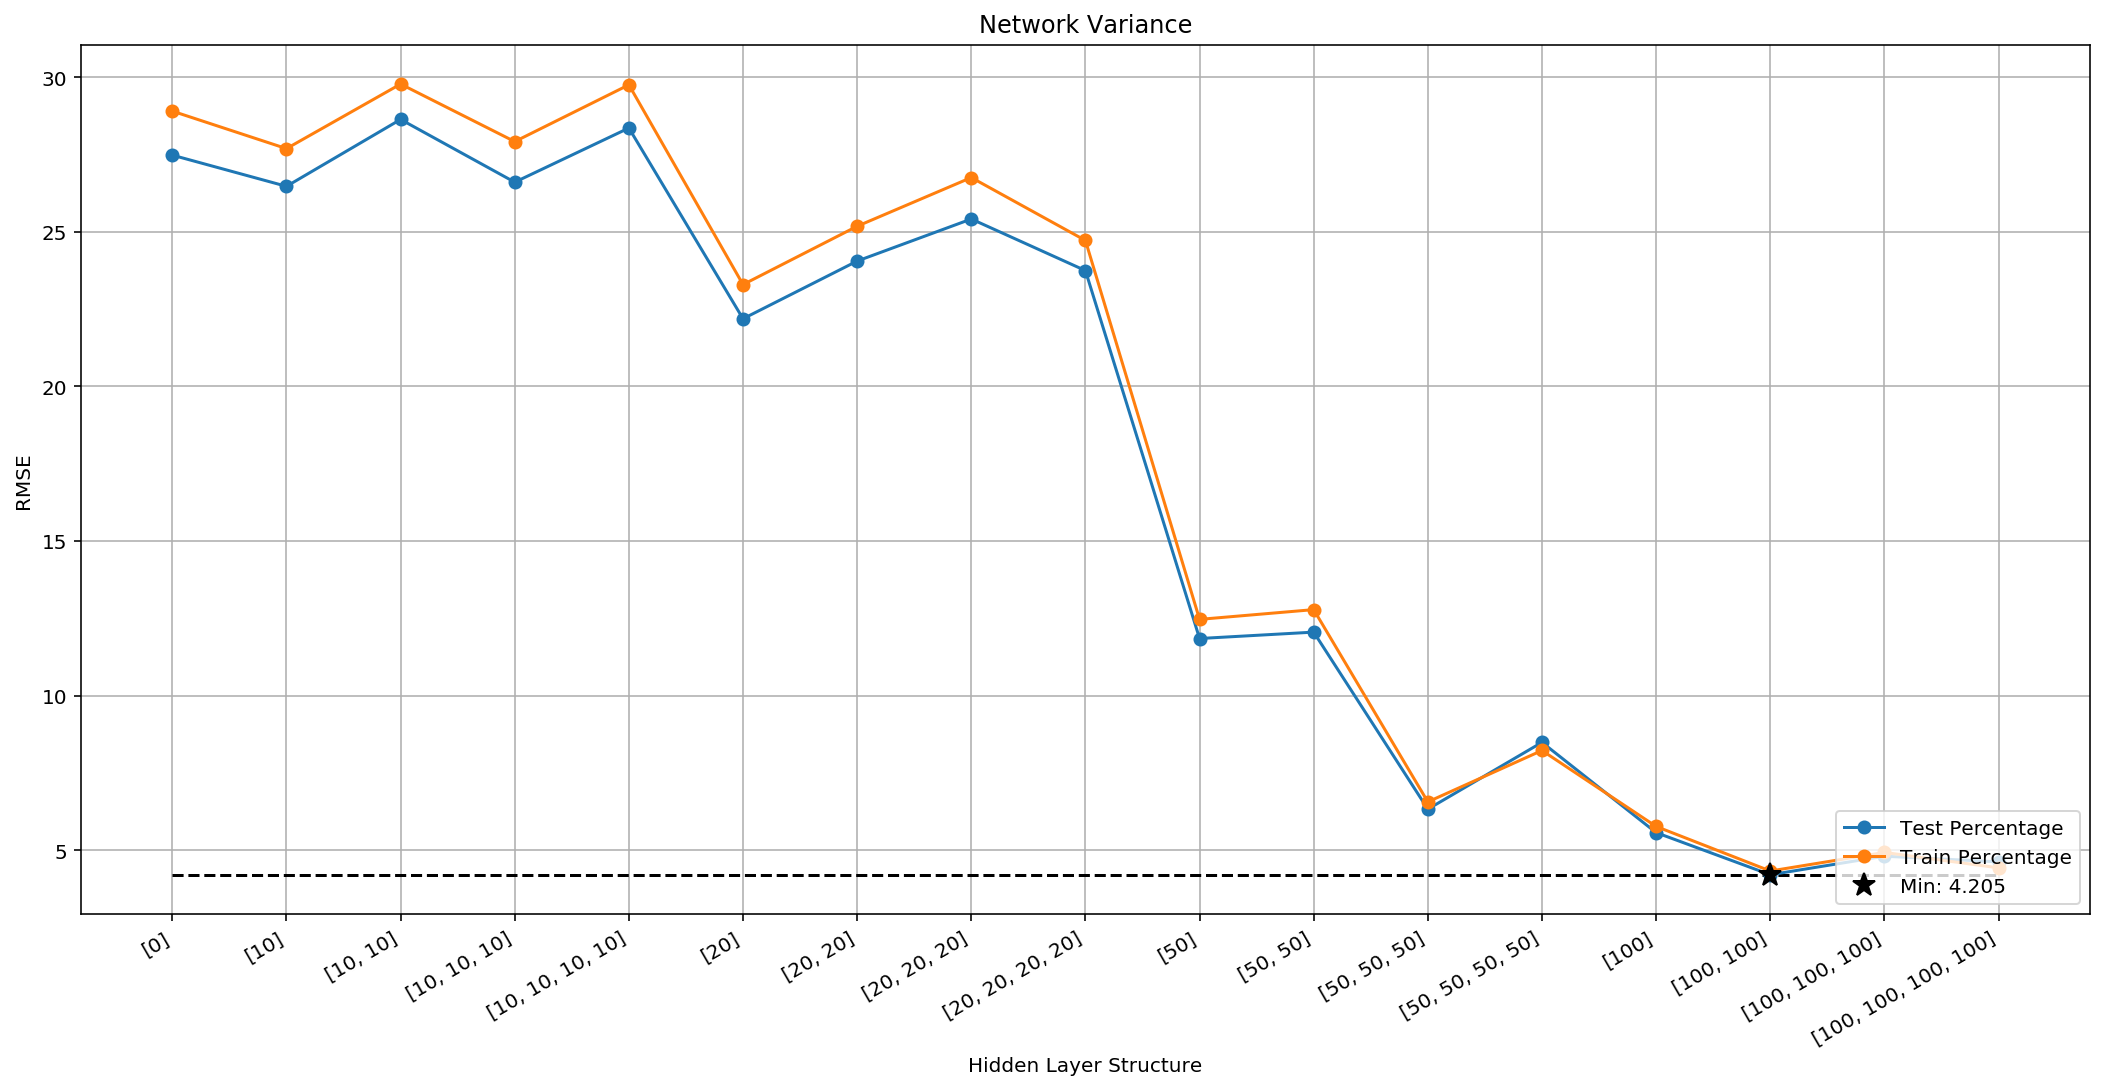

In [13]:
layers = [[0]] + [[nu] * nl for nu in [10, 20, 50, 100] for nl in range(1, 5)]

train_percentage = []
test_percentage = []
top = float('inf')

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], layer, Ttrain.shape[1], activation='relu')
    nnet.train(Xtrain, Ttrain, 50, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(ml.rmse(Ttrain, Y))
    
    Y = nnet.use(Xtest)
    temp = ml.rmse(Ttest, Y)
    test_percentage.append(temp)
    
    if temp < top:
        best_nnet = nnet
        top = temp
    
    f.value += 1
    
plt.figure(figsize=(18, 8))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test Percentage', 'Train Percentage', 'Min: {:.3f}'.format(top)), loc=4)
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');